# Project 2: Credit Risk and Statistical Learning

**Names of all group members:**
- Matthias Wyss (matthias.wyss@epfl.ch)
- William Jallot (william.jallot@epfl.ch)
- Antoine Garin (antoine.garin@epfl.ch)


---

All code below is only suggestive and you may as well use different approaches.

## Exercise 1 - Feature Generation

In [1]:
# Exercise 1.
import numpy as np
import os
np.random.seed(0)  # for reproducibility

# simulate explanatory variables x
m, n = 20000, 10000  # training and test sizes
total = m + n

# x1: age (18-80)
x1 = np.random.uniform(18, 80, size=total)

# x2: monthly income in kCHF (1-15)
x2 = np.random.uniform(1, 15, size=total)

# x3: employment status (0 = salaried, 1 = self-employed)
x3 = np.random.choice([0, 1], size=total, p=[0.9, 0.1])

# stack into a feature matrix
X = np.column_stack((x1, x2, x3))

# a) calculate empirical means and standard deviations over training data
# Select first m samples as training data
X_train = X[:m]  

means = X_train.mean(axis=0)

# We use ddof=1 for sample std deviation
stds = X_train.std(axis=0, ddof=1)  

print("Empirical means (training data):", means)
print("Empirical stds  (training data):", stds)


# b) Suggest other variables that would realistically be relevant in credit scoring.
# (you do not have to implement those of course, just explain your answer in writing)
"""
Other variables that could be relevant for credit scoring include:
- Credit history: past defaults, number of open loans, payment history.
- Debt-to-income ratio: proportion of income already committed to debt payments.
- Employment stability: length of current job, number of job changes.
- Marital status / dependents: may affect financial obligations.
- Education level: can correlate with income stability.
- Age brackets or life stage: young vs. near retirement may carry different risk.
- Housing situation: renter, owner, mortgage payments.
- Other financial indicators: savings, assets, or investments.
These features help better capture the borrower's ability and likelihood to repay.
"""

Empirical means (training data): [48.7426539   7.98652219  0.1017    ]
Empirical stds  (training data): [18.00788849  4.03090363  0.30226094]


"\nOther variables that could be relevant for credit scoring include:\n- Credit history: past defaults, number of open loans, payment history.\n- Debt-to-income ratio: proportion of income already committed to debt payments.\n- Employment stability: length of current job, number of job changes.\n- Marital status / dependents: may affect financial obligations.\n- Education level: can correlate with income stability.\n- Age brackets or life stage: young vs. near retirement may carry different risk.\n- Housing situation: renter, owner, mortgage payments.\n- Other financial indicators: savings, assets, or investments.\nThese features help better capture the borrower's ability and likelihood to repay.\n"

## Exercise 2 - Default Model and Data Generation

In [2]:
# Exercise 2.
# Building the datasets:
np.random.seed(1)  
sigmoid = lambda x: 1. / (1. + np.exp(-x))

# generate uniform random variables for thresholds
xi = np.random.uniform(0, 1, size=total)

# --- build the first dataset ---
# repayment probability function p1
p1 = lambda x1, x2, x3: sigmoid(13.3 - 0.33*x1 + 3.5*x2 - 3*x3)

# labels: 1 = repayment, 0 = default
y1 = lambda xi, x1, x2, x3: (xi <= p1(x1, x2, x3)).astype(int)

# --- build the second dataset ---
# repayment probability function p2
# Here we use a or logic instead of + because the two events are mutually exclusive
# (age below 25 or above 75)
p2 = lambda x1, x2, x3: sigmoid(5 - 10*((x1 < 25) | (x1 > 75)) + 1.1*x2 - x3)

y2 = lambda xi, x1, x2, x3: (xi <= p2(x1, x2, x3)).astype(int)

In [3]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# "model = LogisticRegression().fit(X_data, Y_data)" fits a model
# "pred_X = model.predict_proba(X)" evaluates the model
# (note that it outputs both P(Y=0|X) and P(Y=1|X))
# "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood (also called cross-entropy loss)

# Evaluate labels using the lambda functions
y1_vals = y1(xi, x1, x2, x3)
y2_vals = y2(xi, x1, x2, x3)

# Split train and test
X_train, X_test = X[:m], X[m:]
y1_train, y1_test = y1_vals[:m], y1_vals[m:]
y2_train, y2_test = y2_vals[:m], y2_vals[m:]

# --- Logistic Regression for dataset 1 ---
logreg1 = LogisticRegression().fit(X_train, y1_train)
pred1_train_logreg = logreg1.predict_proba(X_train)
pred1_test_logreg = logreg1.predict_proba(X_test)

loss1_train_logreg = log_loss(y1_train, pred1_train_logreg)
loss1_test_logreg = log_loss(y1_test, pred1_test_logreg)

print("Dataset 1 - Logistic Regression:")
print("Train cross-entropy loss:", f"{loss1_train_logreg:.4f}")
print("Test cross-entropy loss: ", f"{loss1_test_logreg:.4f}")

# --- Logistic Regression for dataset 2 ---
logreg2 = LogisticRegression().fit(X_train, y2_train)

pred2_train_logreg = logreg2.predict_proba(X_train)
pred2_test_logreg = logreg2.predict_proba(X_test)

loss2_train_logreg = log_loss(y2_train, pred2_train_logreg)
loss2_test_logreg = log_loss(y2_test, pred2_test_logreg)

print("\nDataset 2 - Logistic Regression:")
print("Train cross-entropy loss:", f"{loss2_train_logreg:.4f}")
print("Test cross-entropy loss: ", f"{loss2_test_logreg:.4f}")

Dataset 1 - Logistic Regression:
Train cross-entropy loss: 0.0305
Test cross-entropy loss:  0.0341

Dataset 2 - Logistic Regression:
Train cross-entropy loss: 0.1534
Test cross-entropy loss:  0.1519


In [4]:
# Exercise 2.b)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss  
# Calculate normalized data

# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)

# Fit the models for both datasets (this can take up to 60 seconds with SVC)

# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))

# Calculate cross-entropy loss on both datasets for train and test



# --- Standardize features using training set statistics ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# regularization parameter for SVM
C = 0.2
GAMMA = 1/10

# --- SVM for dataset 1 ---
svm1 = SVC(kernel='rbf', C=C, gamma=GAMMA, probability=True).fit(X_train_scaled, y1_train)

# Collect probabilities for dataset 1
pred1_train_svm = svm1.predict_proba(X_train_scaled)
pred1_test_svm  = svm1.predict_proba(X_test_scaled)

loss1_train_svm = log_loss(y1_train, pred1_train_svm)
loss1_test_svm  = log_loss(y1_test, pred1_test_svm)

print("Dataset 1 - SVM (RBF kernel):")
print("Train cross-entropy loss:", f"{loss1_train_svm:.4f}")
print("Test cross-entropy loss: ", f"{loss1_test_svm:.4f}")

# --- SVM for dataset 2 ---
svm2 = SVC(kernel='rbf', C=C, gamma=GAMMA, probability=True).fit(X_train_scaled, y2_train)

# Collect probabilities for dataset 2
pred2_train_svm = svm2.predict_proba(X_train_scaled)
pred2_test_svm  = svm2.predict_proba(X_test_scaled)

loss2_train_svm = log_loss(y2_train, pred2_train_svm)
loss2_test_svm  = log_loss(y2_test, pred2_test_svm)

print("\nDataset 2 - SVM (RBF kernel):")
print("Train cross-entropy loss:", f"{loss2_train_svm:.4f}")
print("Test cross-entropy loss: ", f"{loss2_test_svm:.4f}")

Dataset 1 - SVM (RBF kernel):
Train cross-entropy loss: 0.0324
Test cross-entropy loss:  0.0360

Dataset 2 - SVM (RBF kernel):
Train cross-entropy loss: 0.0719
Test cross-entropy loss:  0.0694


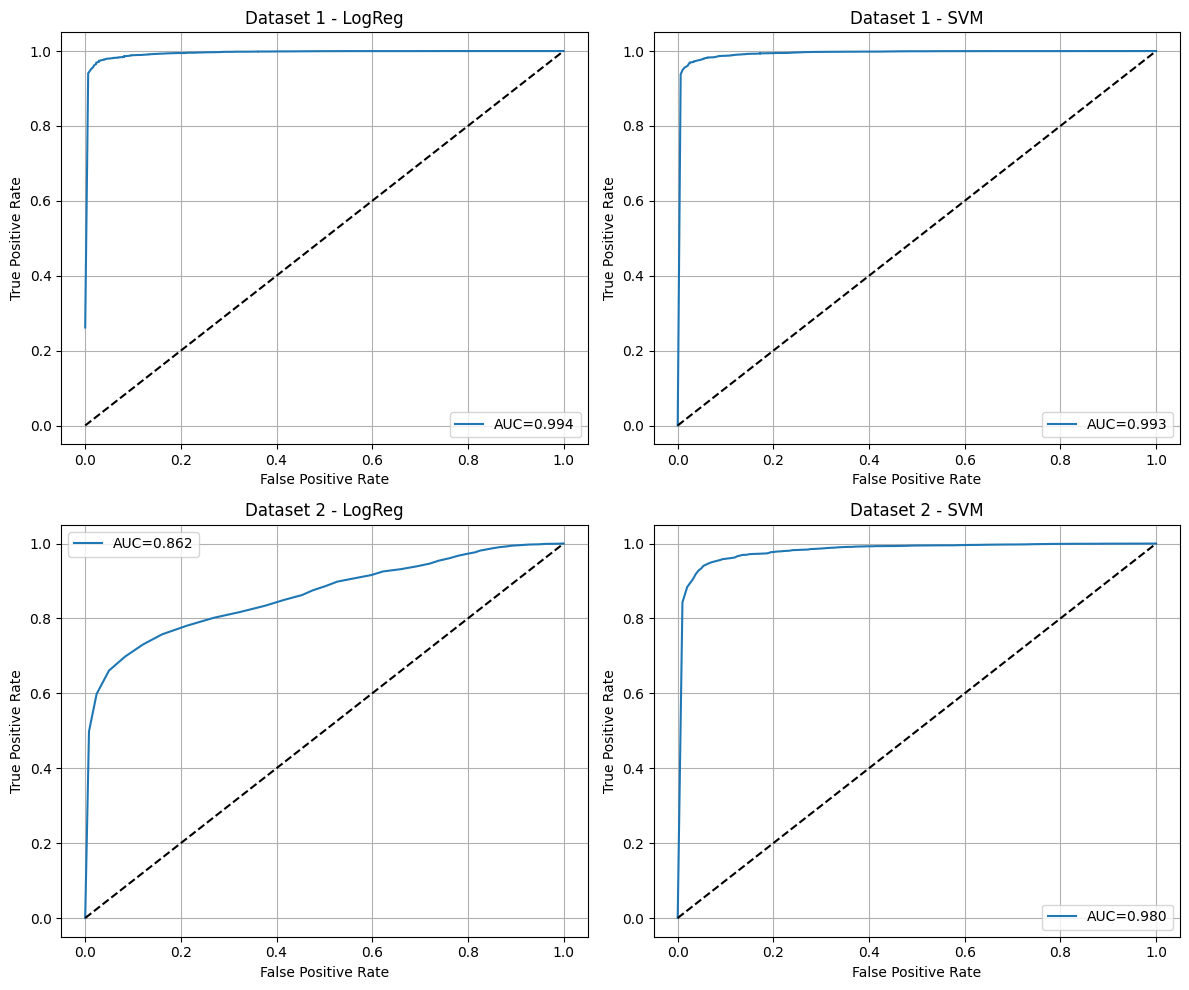

In [5]:
# Exercise 2.c)
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

# To approximately calculate the AUC, it is fine to simply use Riemann sums.
# This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
# then you may simply use the sum
# sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
# as the approximation of the integral (or AUC)


# first data set & logistic regression:
# (the code should be reusable for all cases, only exchanging datasets and predicted probabilities depending on the model)

# Compute and plot the ROC and AUC cruves


# second data set & logistic regression:


# first data set and SVM:


# second data set and SVM:

np.random.seed(0)
# second data set and SVM:

def compute_roc_auc(y_true, y_pred_probs, thresholds):
    """
    Compute ROC curve points (FPR, TPR) and approximate AUC using Riemann sum.
    
    Parameters:
        y_true: array of true binary labels (0 or 1)
        y_pred_probs: array of predicted probabilities for Y=1
        thresholds: array of threshold values to evaluate
    
    Returns:
        fpr: array of false positive rates
        tpr: array of true positive rates
        auc: approximate AUC
    """
    tpr = []
    fpr = []
    
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    
    for c in thresholds:
        y_pred = (y_pred_probs >= c).astype(int)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        tpr.append(TP / P)
        fpr.append(FP / N)

    tpr = np.array(tpr)
    fpr = np.array(fpr)

    # Sort by FPR (ascending) before applying trapezoidal rule
    idx = np.argsort(fpr)
    fpr = fpr[idx]
    tpr = tpr[idx]

    # Riemann sum (trapezoidal) AUC
    auc = np.sum((tpr[:-1] + tpr[1:]) / 2 * (fpr[1:] - fpr[:-1]))

    return fpr, tpr, auc

# Plot all 4 cases:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # flatten to a 1D array for easy looping

cases = [
    ("Dataset 1 - LogReg", y1_test, pred1_test_logreg[:,1]),
    ("Dataset 1 - SVM",    y1_test, pred1_test_svm[:,1]),
    ("Dataset 2 - LogReg", y2_test, pred2_test_logreg[:,1]),
    ("Dataset 2 - SVM",    y2_test, pred2_test_svm[:,1]),
]

for ax, (title, y_true, preds) in zip(axes, cases):
    fpr, tpr, auc = compute_roc_auc(y_true, preds, ths)

    # ROC curve
    ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")

    # Random classifier line
    ax.plot([0, 1], [0, 1], "k--")

    # Labels and style
    ax.set_title(title)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.grid(True)
    ax.legend()

plt.tight_layout()

os.makedirs("outputs", exist_ok=True)
plt.savefig(os.path.join("outputs", "roc_subplots.png"))
plt.show()

## Exercise 3 - Lending Strategies

In [6]:
# Exercise 3.

# Set model parameters and define matrix D
n_scenarios = 50000
loan_amount = 1000

x1_test = X_test[:, 0]
x2_test = X_test[:, 1]
x3_test = X_test[:, 2]

xi_test = np.random.uniform(0, 1, (len(X_test), n_scenarios))

true_probs_test = p2(x1_test, x2_test, x3_test)

print(f"Generating simulation matrix D ({len(X_test)} applicants x {n_scenarios} scenarios)...")
# Draw independent random variables xi ~ Unif(0,1)
# We generate the boolean matrix D directly:
# D_ik = 1 if xi <= p2(x), else 0
D = (xi_test <= true_probs_test[:, None]).astype(int)
print("Matrix D generated.\n")

Generating simulation matrix D (10000 applicants x 50000 scenarios)...
Matrix D generated.



In [31]:
def evaluate_strategy(strategy_name, selection_mask, interest_rate, D_matrix):
    """
    Helper function to calculate PnL, plot histogram, and compute metrics.
    """
    # Filter the D matrix for only the selected applicants
    # resulting shape: (n_selected, n_scenarios)
    D_selected = D_matrix[selection_mask, :]
    
    n_selected = D_selected.shape[0]
    
    if n_selected == 0:
        print(f"--- {strategy_name} ---")
        print("No applicants selected. PnL is 0.")
        return

    # Calculate PnL for each scenario
    # Profit = (Repayments * Loan * Interest) - (Defaults * Loan)
    # Repayment count per scenario (sum columns)
    repayments = np.sum(D_selected, axis=0) # shape: (n_scenarios,)
    defaults = n_selected - repayments
    
    # PnL Vector
    pnl = (repayments * loan_amount * interest_rate) - (defaults * loan_amount)
    
    # Expected Profit & Loss
    expected_pnl = np.mean(pnl)
    
    # 95% VaR (Value at Risk)
    # We take the 5th percentile of the PnL distribution.
    loss = -pnl
    var_95 = np.percentile(loss, 95)
    
    # 95% ES (Expected Shortfall)
    # The average of the PnL values that fall below the VaR threshold.
    es_95 = loss[loss >= var_95].mean()
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.hist(pnl, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    plt.axvline(expected_pnl, color='red', linestyle='--', linewidth=2, label=f'Exp PnL: {expected_pnl:,.0f}')
    plt.axvline(-var_95, color='orange', linestyle='--', linewidth=2, label=f'95% VaR: {var_95:,.0f}')
    plt.axvline(-es_95, color='purple', linestyle=':', linewidth=2, label=f'95% ES: {es_95:,.0f}')
    
    plt.title(f"PnL Distribution: {strategy_name} (Selected: {n_selected})")
    plt.xlabel("Profit & Loss (CHF)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join("outputs", f"pnl_{strategy_name.replace(' ', '_').lower()}.png"))
    plt.show()
    
    # Print results
    print(f"--- {strategy_name} ---")
    print(f"Applicants Selected: {n_selected} over {len(X_test)}")
    print(f"Interest Rate:       {interest_rate*100}%")
    print(f"Expected PnL:        CHF {expected_pnl:,.2f}")
    print(f"95% VaR:             CHF {var_95:,.2f}")
    print(f"95% ES:              CHF {es_95:,.2f}")
    print("-" * 30 + "\n")

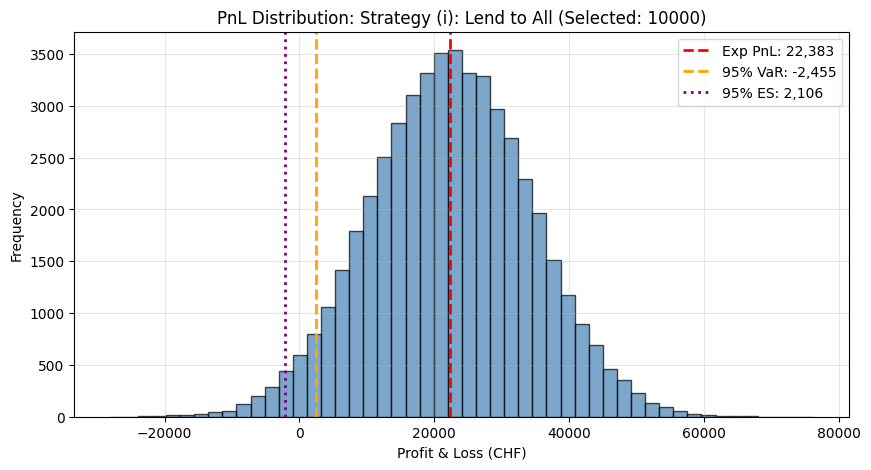

--- Strategy (i): Lend to All ---
Applicants Selected: 10000 over 10000
Interest Rate:       5.5%
Expected PnL:        CHF 22,383.19
95% VaR:             CHF -2,455.00
95% ES:              CHF 2,106.14
------------------------------



In [32]:
# Scenario 1: Lend to everyone at 5.5% interest
# Define Portfolio and possible outcomes for this portfolio using matrix D
# Plot the histogram of profits and losses
# Calculate expected profit and losses, compute 95%-VaR and 95%-ES

mask_all = np.ones(len(X_test), dtype=bool)
evaluate_strategy("Strategy (i): Lend to All", mask_all, 0.055, D)

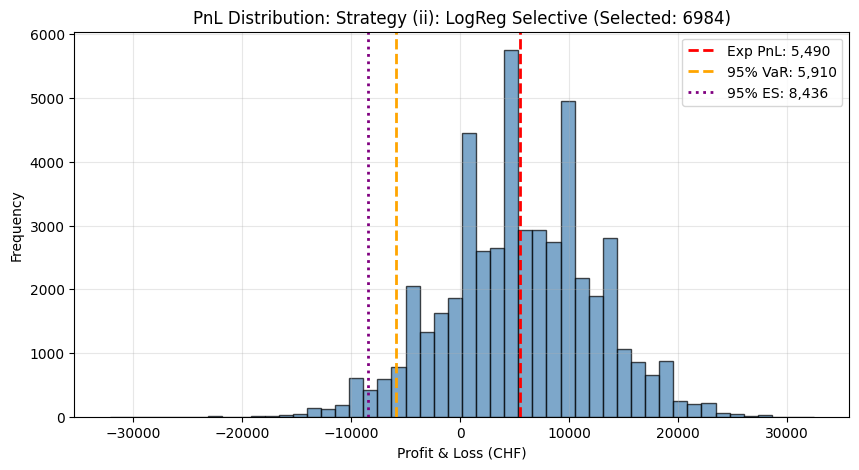

--- Strategy (ii): LogReg Selective ---
Applicants Selected: 6984 over 10000
Interest Rate:       1.0%
Expected PnL:        CHF 5,489.51
95% VaR:             CHF 5,910.00
95% ES:              CHF 8,435.51
------------------------------



In [33]:
# Scenario 2: Lend selectively (LogReg >= 95%) at 1% interest
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the logistic regression model
# Plot the histogram of profits and losses
# Calculate expected profit and losses, compute 95%-VaR and 95%-ES
mask_logreg = pred2_test_logreg[:, 1] >= 0.95
evaluate_strategy("Strategy (ii): LogReg Selective", mask_logreg, 0.01, D)

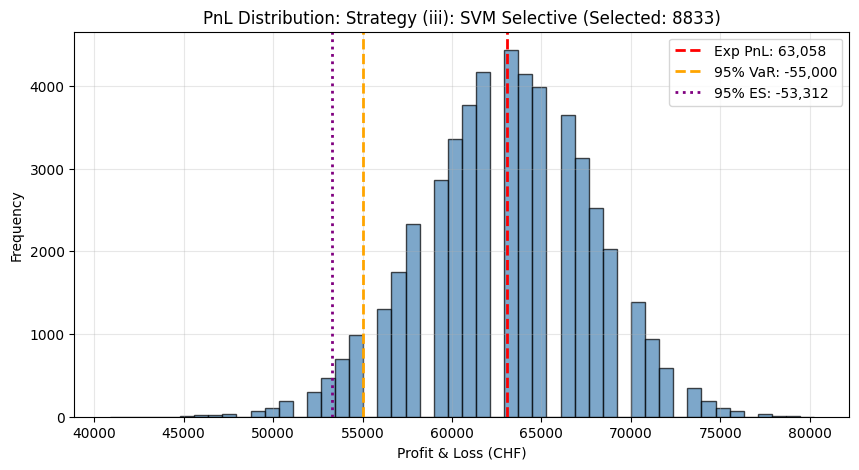

--- Strategy (iii): SVM Selective ---
Applicants Selected: 8833 over 10000
Interest Rate:       1.0%
Expected PnL:        CHF 63,057.76
95% VaR:             CHF -55,000.00
95% ES:              CHF -53,312.36
------------------------------



In [34]:
# Scenario 3: Lend selectively (SVM >= 95%) at 1% interest
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the SVM model
# Plot the histogram of profits and losses
# Calculate expected profit and losses, compute 95%-VaR and 95%-ES
mask_svm = pred2_test_svm[:, 1] >= 0.95
evaluate_strategy("Strategy (iii): SVM Selective", mask_svm, 0.01, D)